In [318]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import json

from sklearn.model_selection import (
    train_test_split, cross_val_score, ShuffleSplit, GridSearchCV)
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA

from xgboost import XGBRegressor

In [319]:
df = pd.read_csv('/home/akeemlag/Downloads/car_price_prediction.csv')

In [320]:
"""EXPLORATORY DATA ANALYSIS"""

'EXPLORATORY DATA ANALYSIS'

In [321]:
df.columns = df.columns.str.replace(' ', '_')

df.head()

,ID,Price,Levy,Manufacturer,Model,Prod._year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [322]:
print(df.shape)
print(df.info())

(19237, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod._year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather_interior  19237 non-null  object 
 8   Fuel_type         19237 non-null  object 
 9   Engine_volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear_box_type     19237 non-null  object 
 13  Drive_wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-

In [323]:
df.nunique()

ID                  18924
Price                2315
Levy                  559
Manufacturer           65
Model                1590
Prod._year             54
Category               11
Leather_interior        2
Fuel_type               7
Engine_volume         107
Mileage              7687
Cylinders              13
Gear_box_type           4
Drive_wheels            3
Doors                   3
Wheel                   2
Color                  16
Airbags                17
dtype: int64

""" There roughly 6000 rows with this kind of data that are not int and not null
If we remove such humongous dataset, it will impact our ds training
Proposition is to conver the remaining value to an int, calculate the mean per year and replace the 
the - with the mean
"""

In [324]:
def isInt(x):
    try:
        int(x)
    except:
        return None
    return int(x)

In [325]:
df.Mileage.isna().sum()

0

In [326]:
df.Mileage = df.Mileage.apply(lambda x: x.split(' ')[0])

In [327]:
# Convert Levy to int
cols_to_convert = ['Levy', 'Mileage', 'Cylinders']
for col in cols_to_convert:
    print('current col: ', col)
    df[col] = df[col].apply(isInt)
    if df[col].isna().sum() > 0:
        df[col] = df[col].fillna(df[col].mean())
    df[col] = df[col].astype(int)


current col:  Levy
current col:  Mileage
current col:  Cylinders


In [328]:
def create_turbo_col(x):
    try:
        if len(x.split(' '))>1:
            return x[1]
        else:
            return 'Not Turbo'
    except ValueError:
        return 0

In [329]:
df['Turbo_engine'] = df.Engine_volume.apply(create_turbo_col)

In [330]:
df.Engine_volume = df.Engine_volume.str.split(' ').str[0]
df.Engine_volume = df.Engine_volume.astype(float)

In [331]:
df.describe()

,ID,Price,Levy,Prod._year,Engine_volume,Mileage,Cylinders,Airbags
count,1.923700e+04,1.923700e+04,19237.000000,19237.000000,19237.000000,1.923700e+04,19237.000000,19237.000000
mean,4.557654e+07,1.855593e+04,906.584603,2010.912824,2.307990,1.532236e+06,4.582991,6.582627
std,9.365914e+05,1.905813e+05,385.733647,5.668673,0.877805,4.840387e+07,1.199933,4.320168
min,2.074688e+07,1.000000e+00,87.000000,1939.000000,0.000000,0.000000e+00,1.000000,0.000000
25%,4.569837e+07,5.331000e+03,730.000000,2009.000000,1.800000,7.013900e+04,4.000000,4.000000
50%,4.577231e+07,1.317200e+04,906.000000,2012.000000,2.000000,1.260000e+05,4.000000,6.000000
75%,4.580204e+07,2.207500e+04,917.000000,2015.000000,2.500000,1.888880e+05,4.000000,12.000000
max,4.581665e+07,2.630750e+07,11714.000000,2020.000000,20.000000,2.147484e+09,16.000000,16.000000


In [332]:
# Check if any cols contain values that are non int in the numerical cols
numerical_cols = df.select_dtypes(include=['int', 'float']).columns
print('numerical_cols: ', numerical_cols)
categorical_cols = df.select_dtypes(include=['object']).columns
print('categorical_cols: ',categorical_cols)

numerical_cols:  Index(['ID', 'Price', 'Levy', 'Prod._year', 'Engine_volume', 'Mileage',
       'Cylinders', 'Airbags'],
      dtype='object')
categorical_cols:  Index(['Manufacturer', 'Model', 'Category', 'Leather_interior', 'Fuel_type',
       'Gear_box_type', 'Drive_wheels', 'Doors', 'Wheel', 'Color',
       'Turbo_engine'],
      dtype='object')


Let's create a corr heatmap to see features that are closely related 
Features with a 0.85 corr will dropped in place of that which does not 
have an outlier

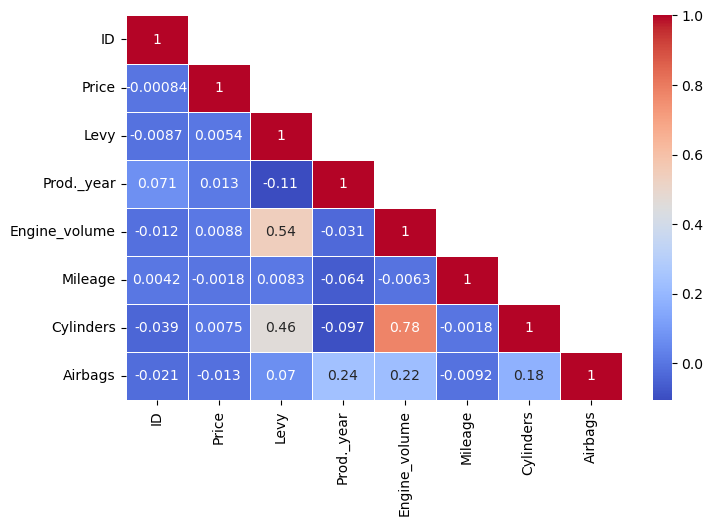

In [333]:
# Corr between numerical cols
corr = df[numerical_cols].corr()
# Remove repetition
plt.figure(figsize=(8,5))
mask = ~np.tri(corr.shape[0], k=0, dtype=bool)

sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5);

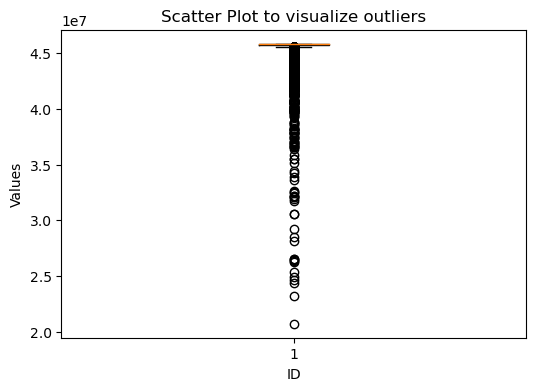

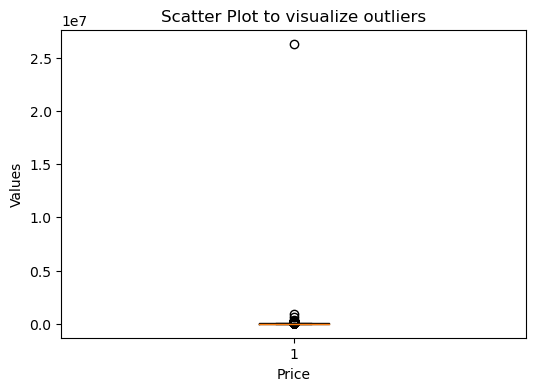

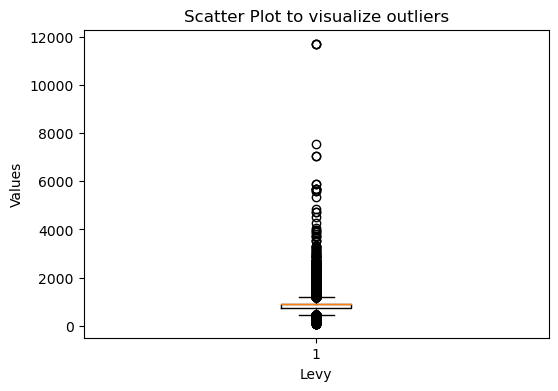

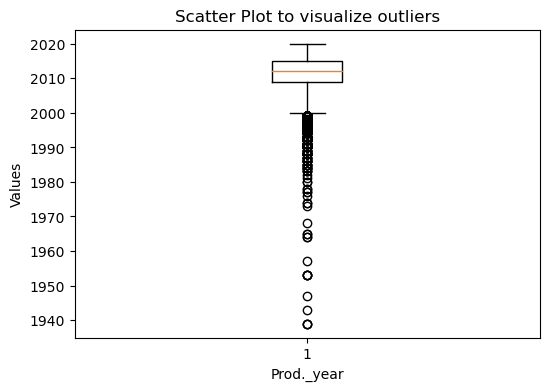

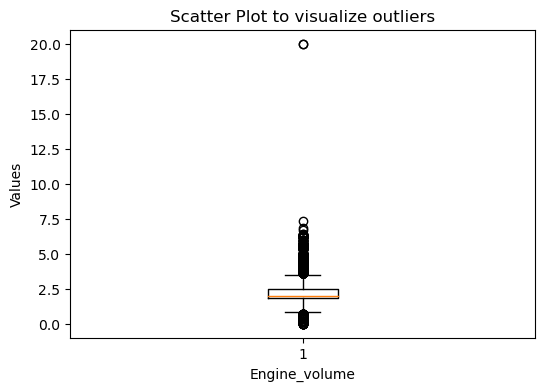

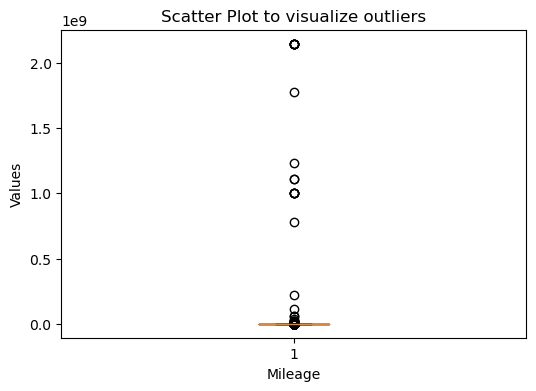

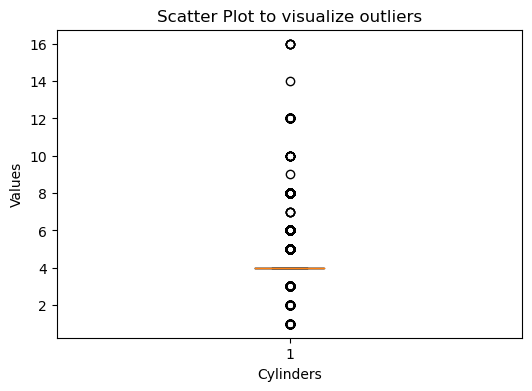

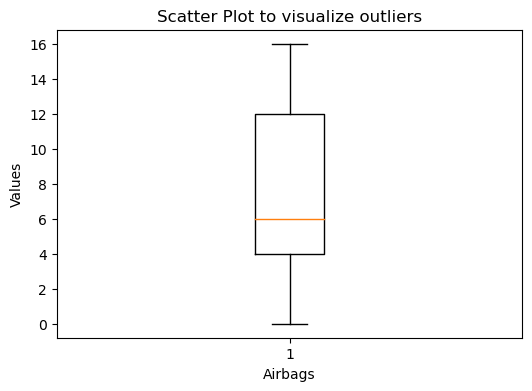

In [334]:
#Create a boc plot to visualize outliers in the numerical cols
for col in numerical_cols:
    plt.figure(figsize=(6,4))
    plt.boxplot(df[col])
    plt.title('Scatter Plot to visualize outliers')
    plt.xlabel(col)
    plt.ylabel('Values')


In [335]:
# Use quantile to remove outliers in our pricing
def get_and_remove_outliers(col, df):
    min_threshold, max_threshold = df[col].quantile([0.10, 0.90])
    
    print(f'upper_limit: ', {max_threshold})
    print(f'lower_limit: ', {min_threshold})
    no_outliers = df[(df[col] < max_threshold) & (df[col] > min_threshold)]

    return no_outliers

In [340]:
df = get_and_remove_outliers(df=df, col='Levy')

upper_limit:  {1202.0}
lower_limit:  {531.0}


In [336]:
df = get_and_remove_outliers(df=df, col='Price')

upper_limit:  {38609.0}
lower_limit:  {627.0}


In [337]:
df = get_and_remove_outliers(df=df, col='Mileage')

upper_limit:  {265906.8}
lower_limit:  {30000.0}


In [341]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9673 entries, 1 to 19234
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                9673 non-null   int64  
 1   Price             9673 non-null   int64  
 2   Levy              9673 non-null   int64  
 3   Manufacturer      9673 non-null   object 
 4   Model             9673 non-null   object 
 5   Prod._year        9673 non-null   int64  
 6   Category          9673 non-null   object 
 7   Leather_interior  9673 non-null   object 
 8   Fuel_type         9673 non-null   object 
 9   Engine_volume     9673 non-null   float64
 10  Mileage           9673 non-null   int64  
 11  Cylinders         9673 non-null   int64  
 12  Gear_box_type     9673 non-null   object 
 13  Drive_wheels      9673 non-null   object 
 14  Doors             9673 non-null   object 
 15  Wheel             9673 non-null   object 
 16  Color             9673 non-null   object 
 17 

<AxesSubplot: >

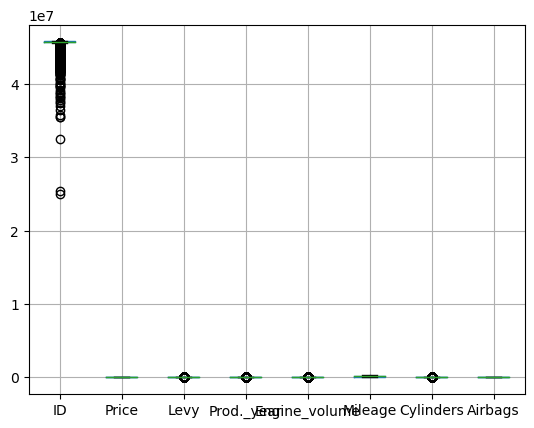

In [342]:
df.boxplot()

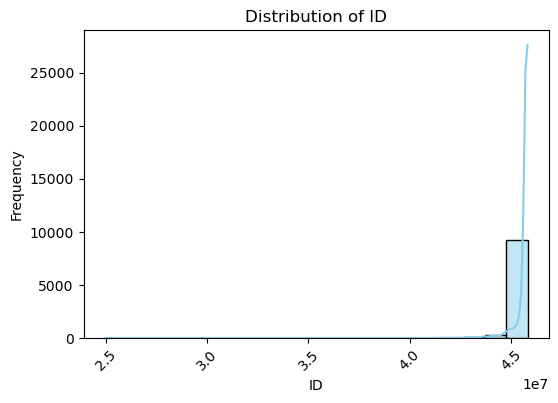

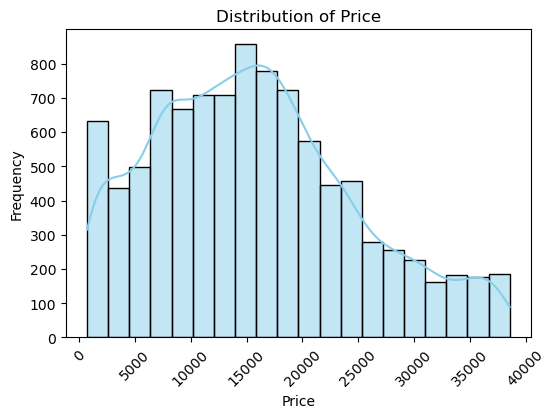

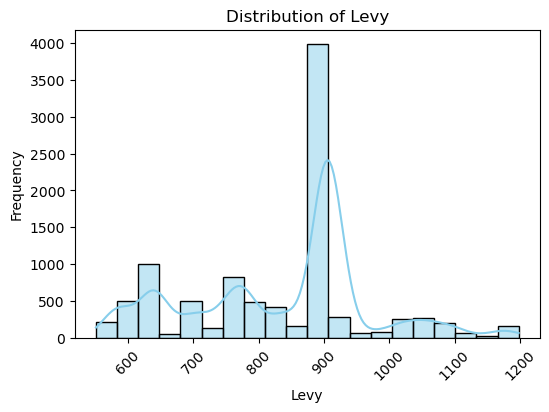

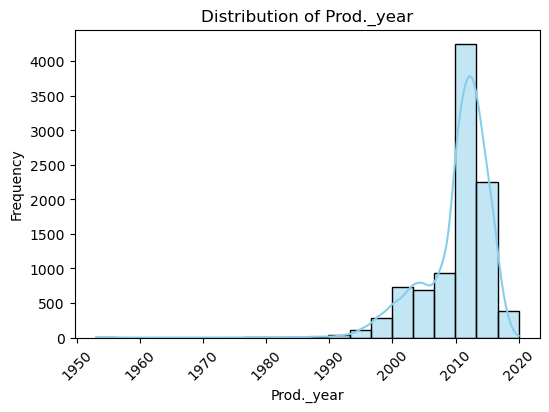

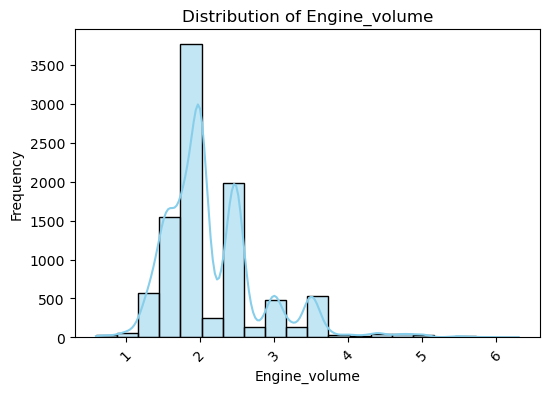

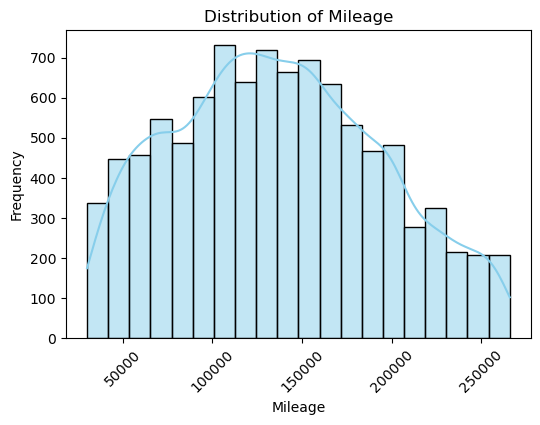

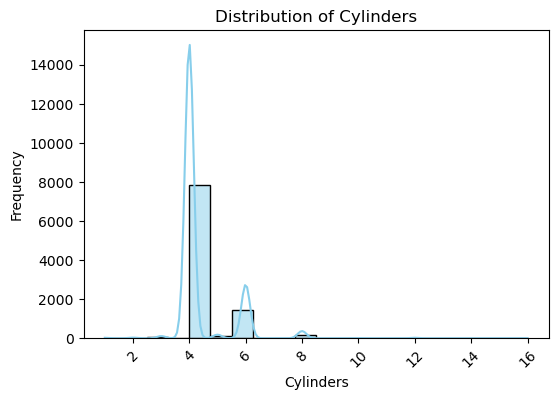

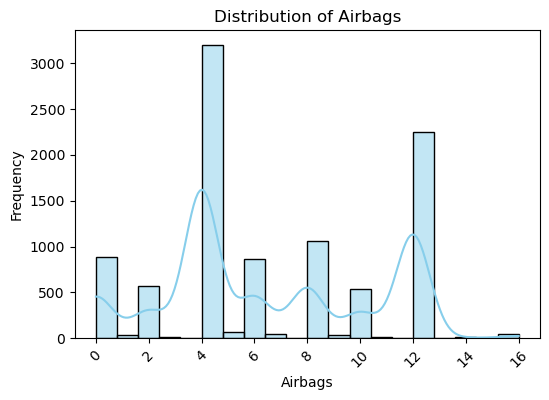

In [343]:
for col in numerical_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], bins=20, color='skyblue', kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45);

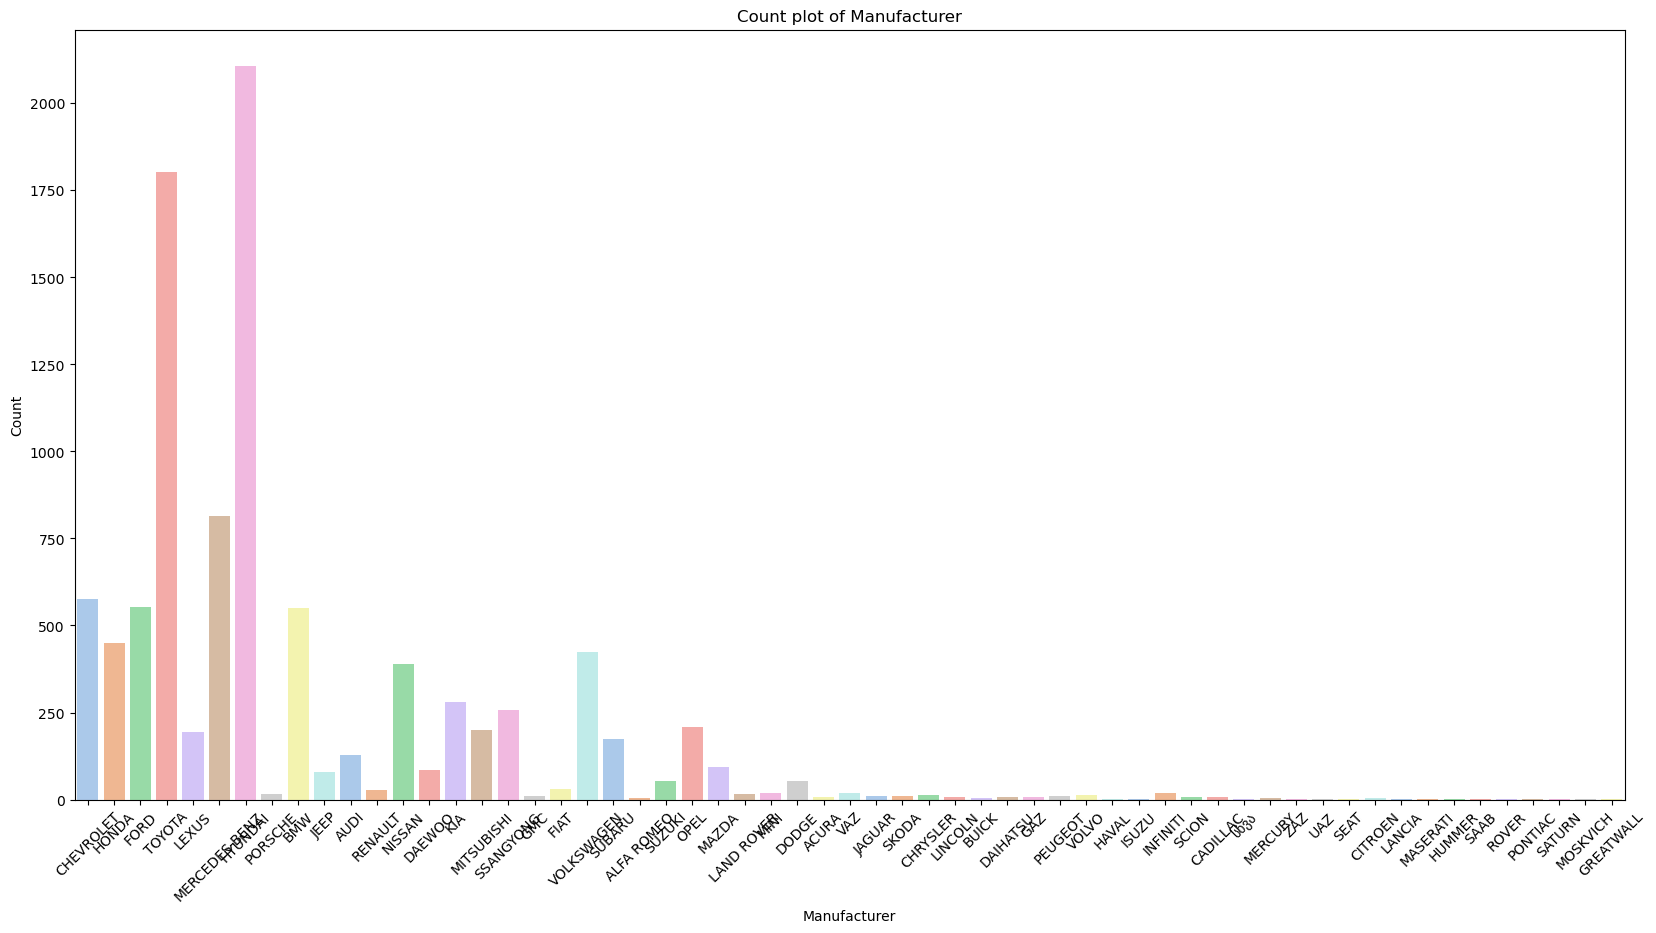

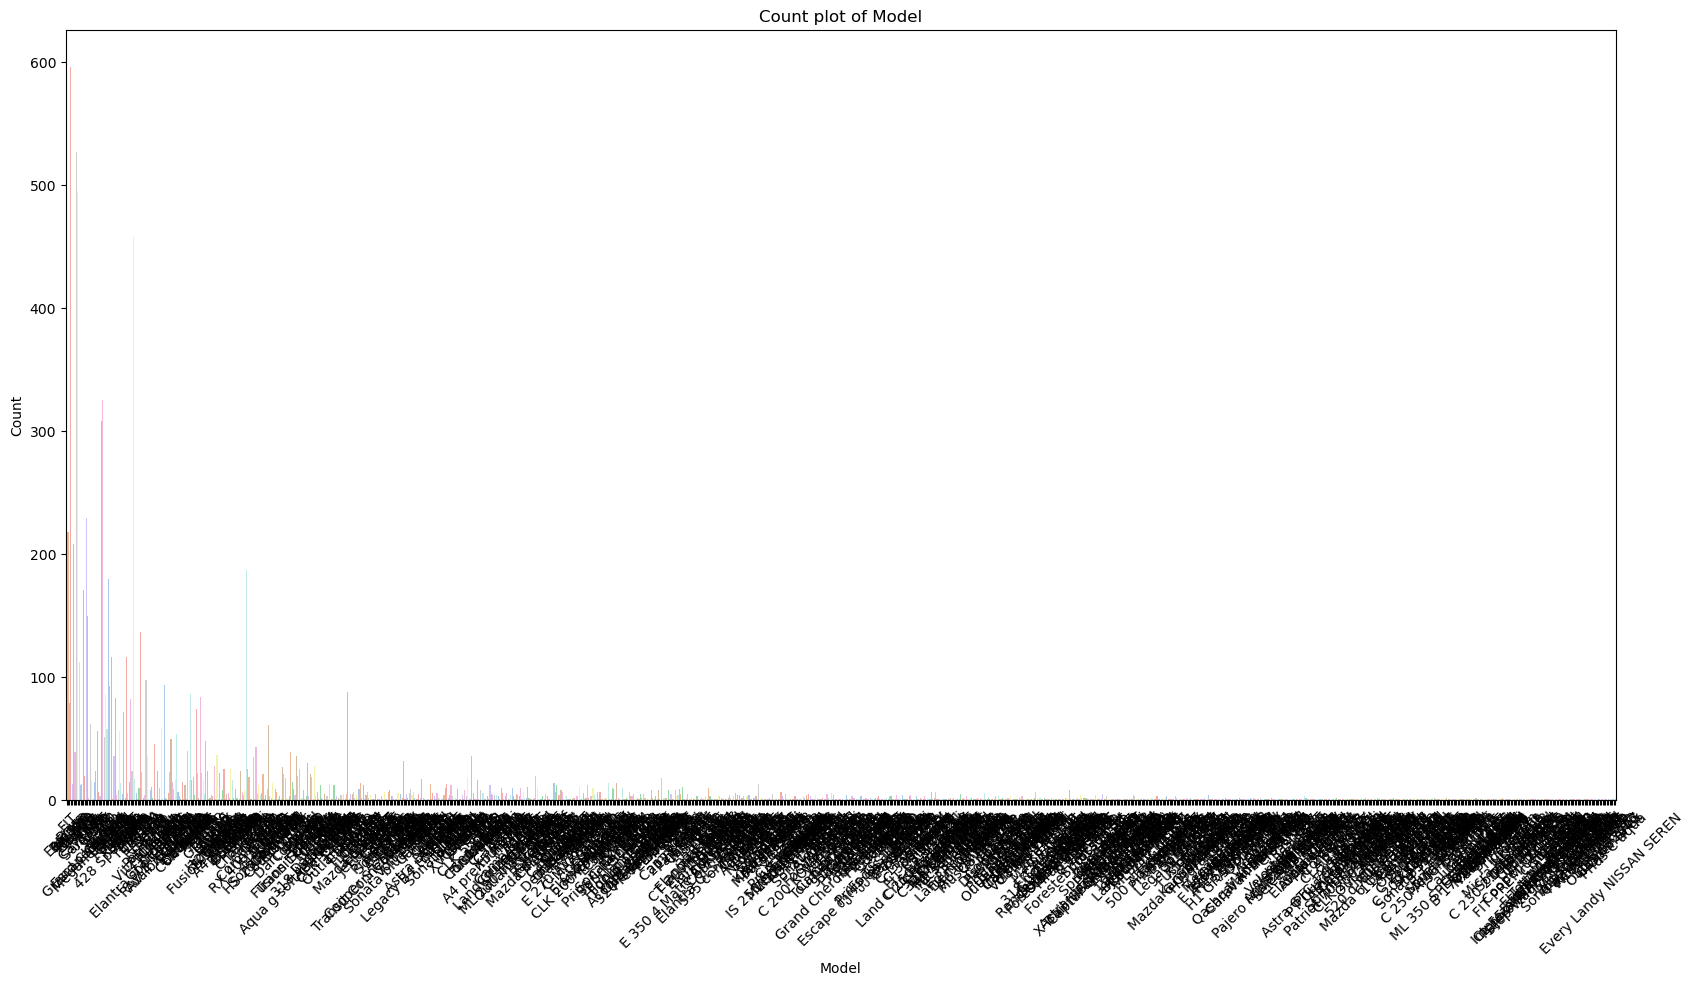

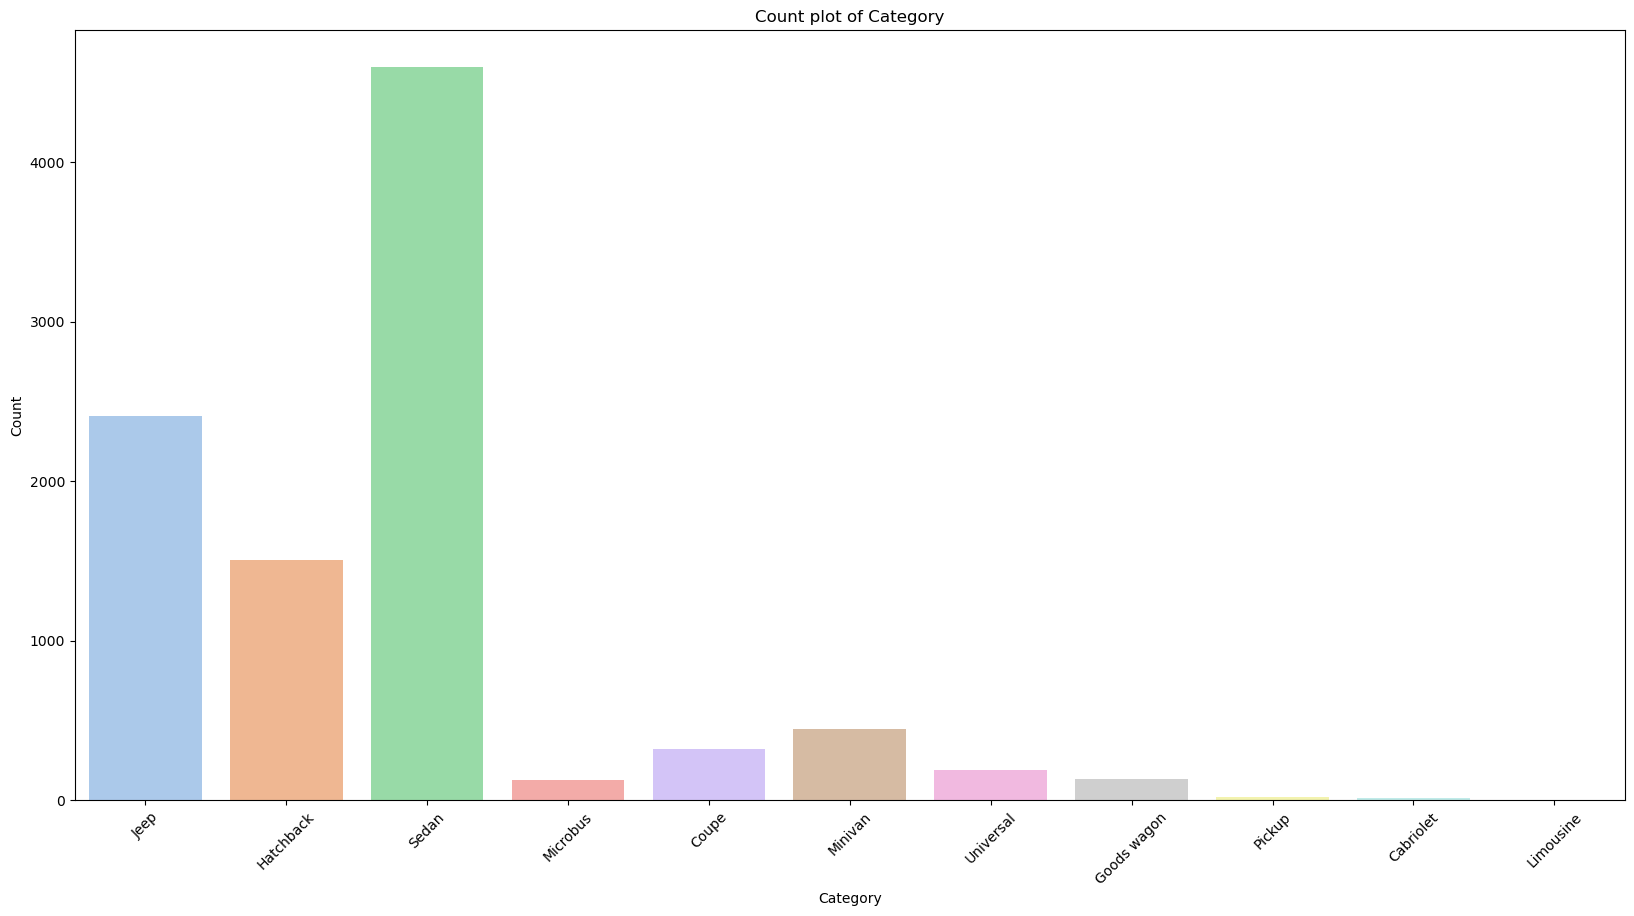

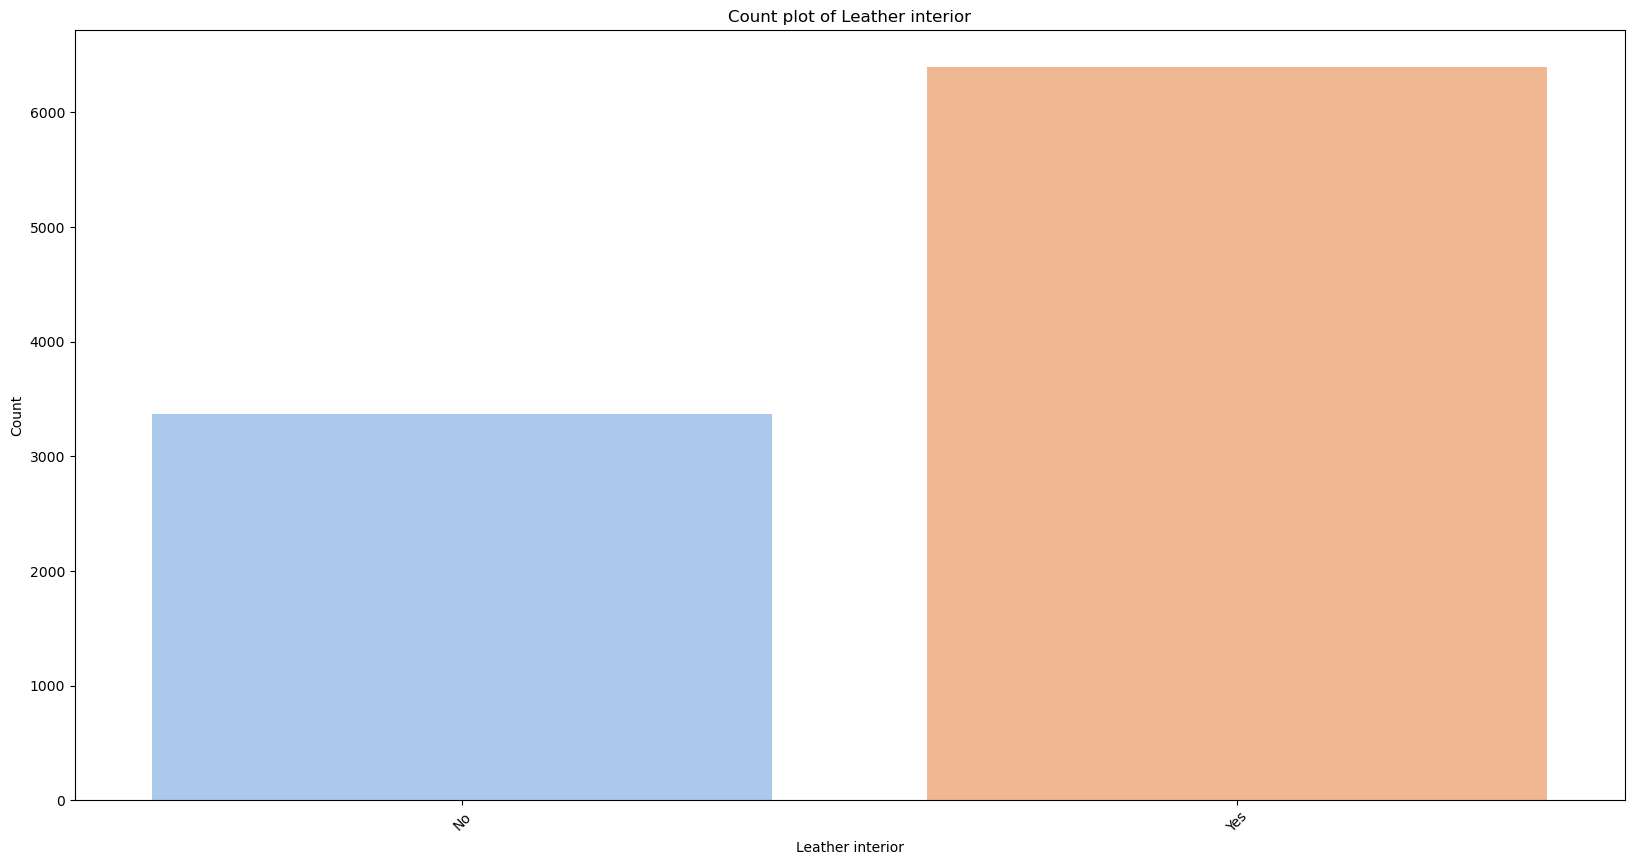

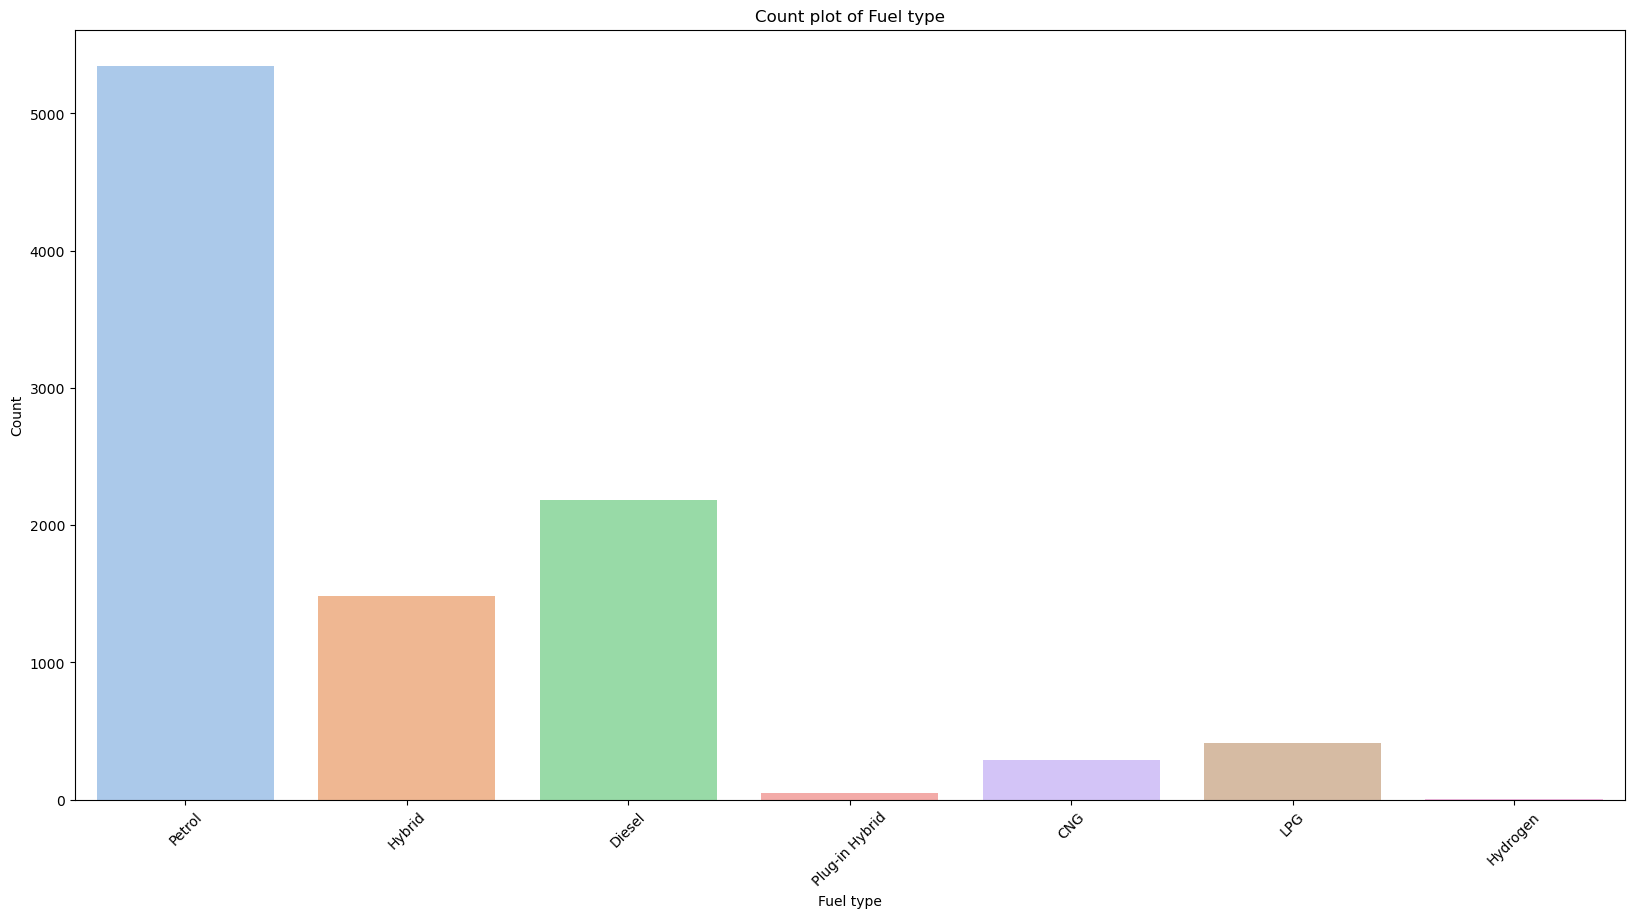

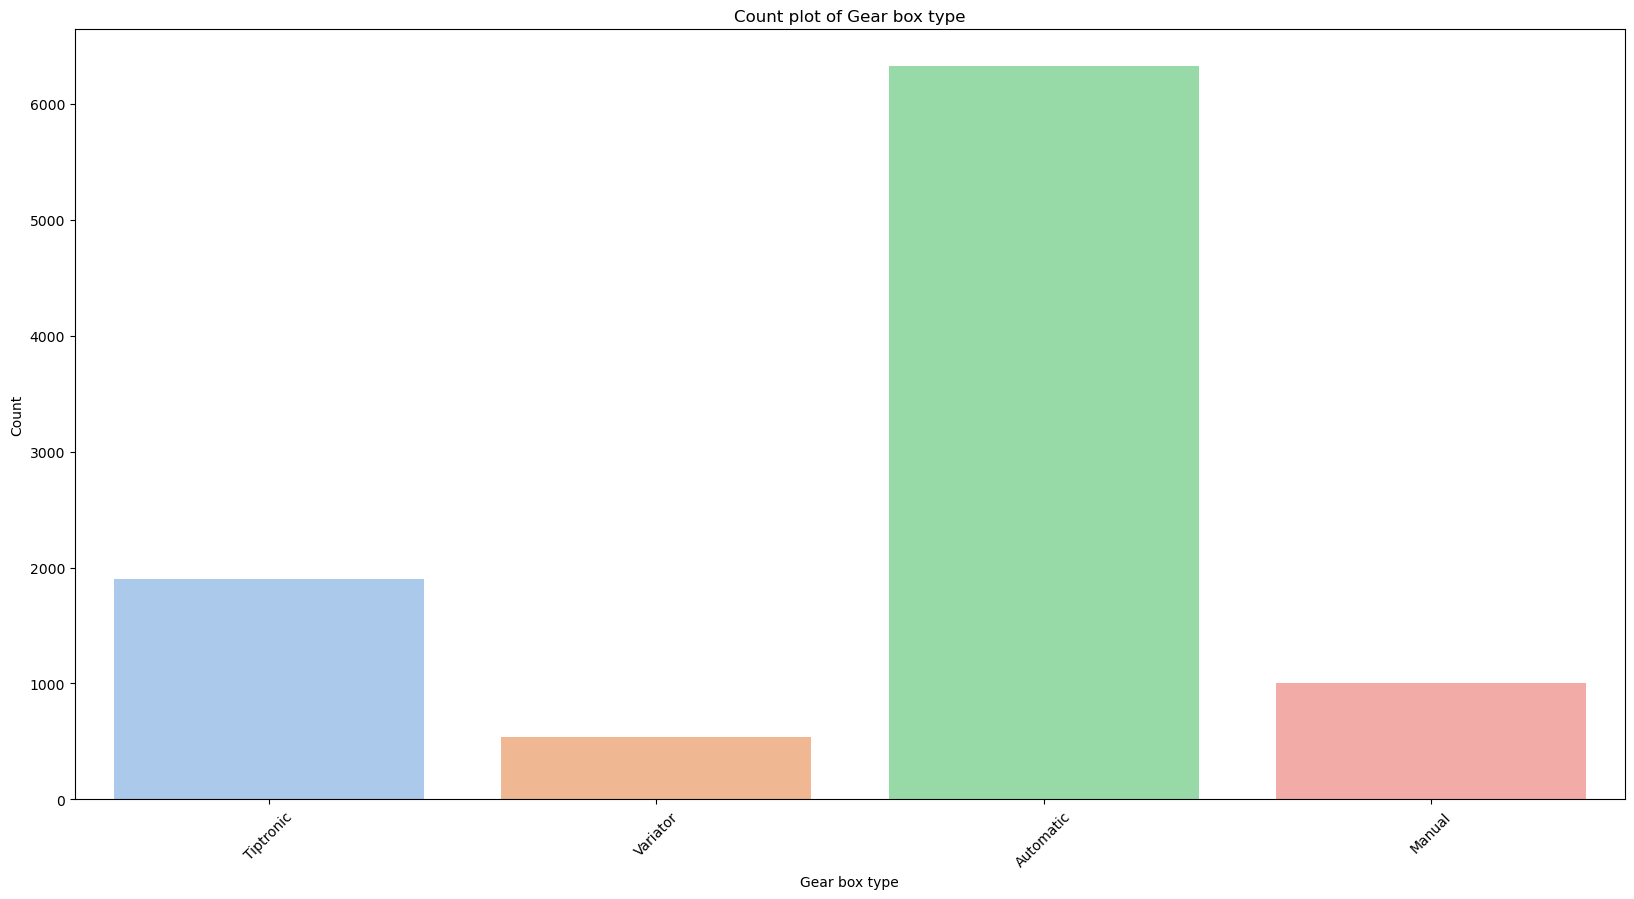

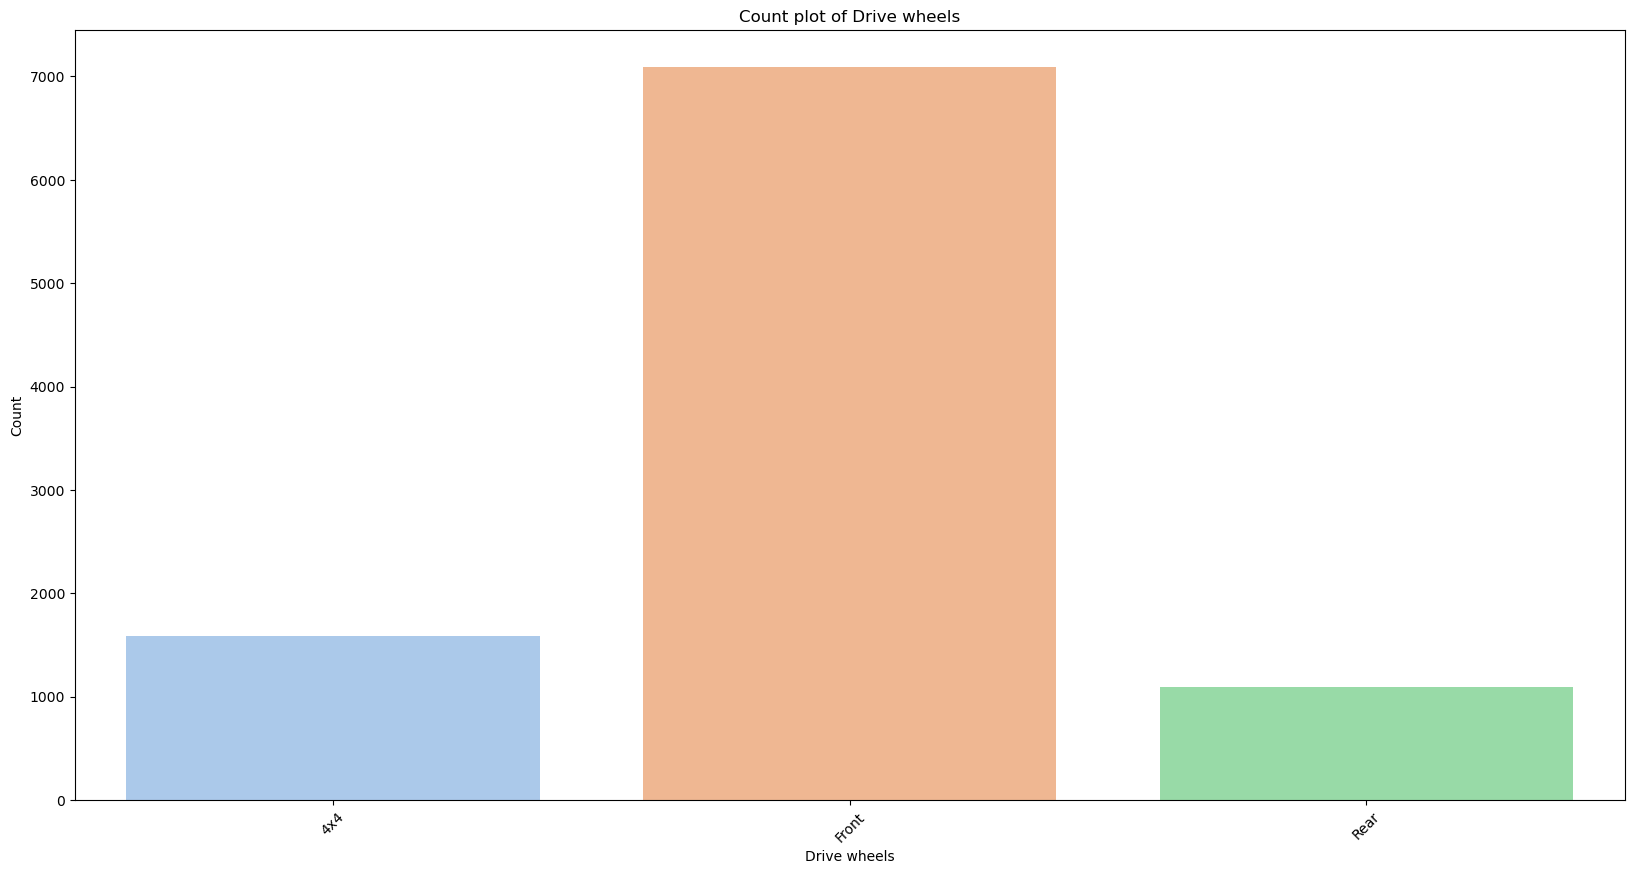

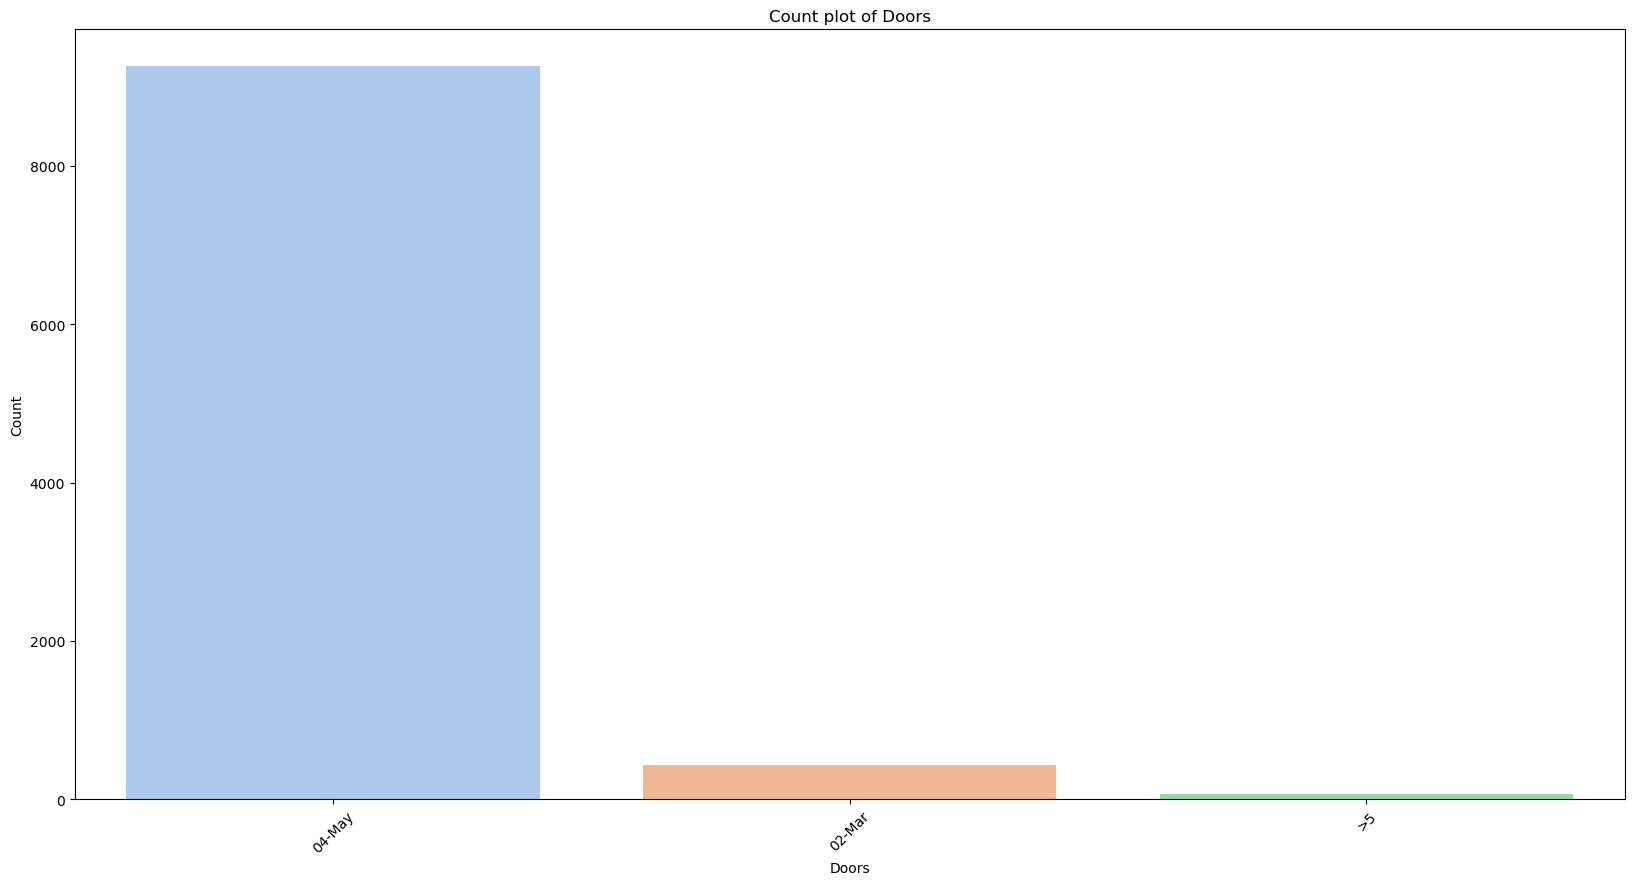

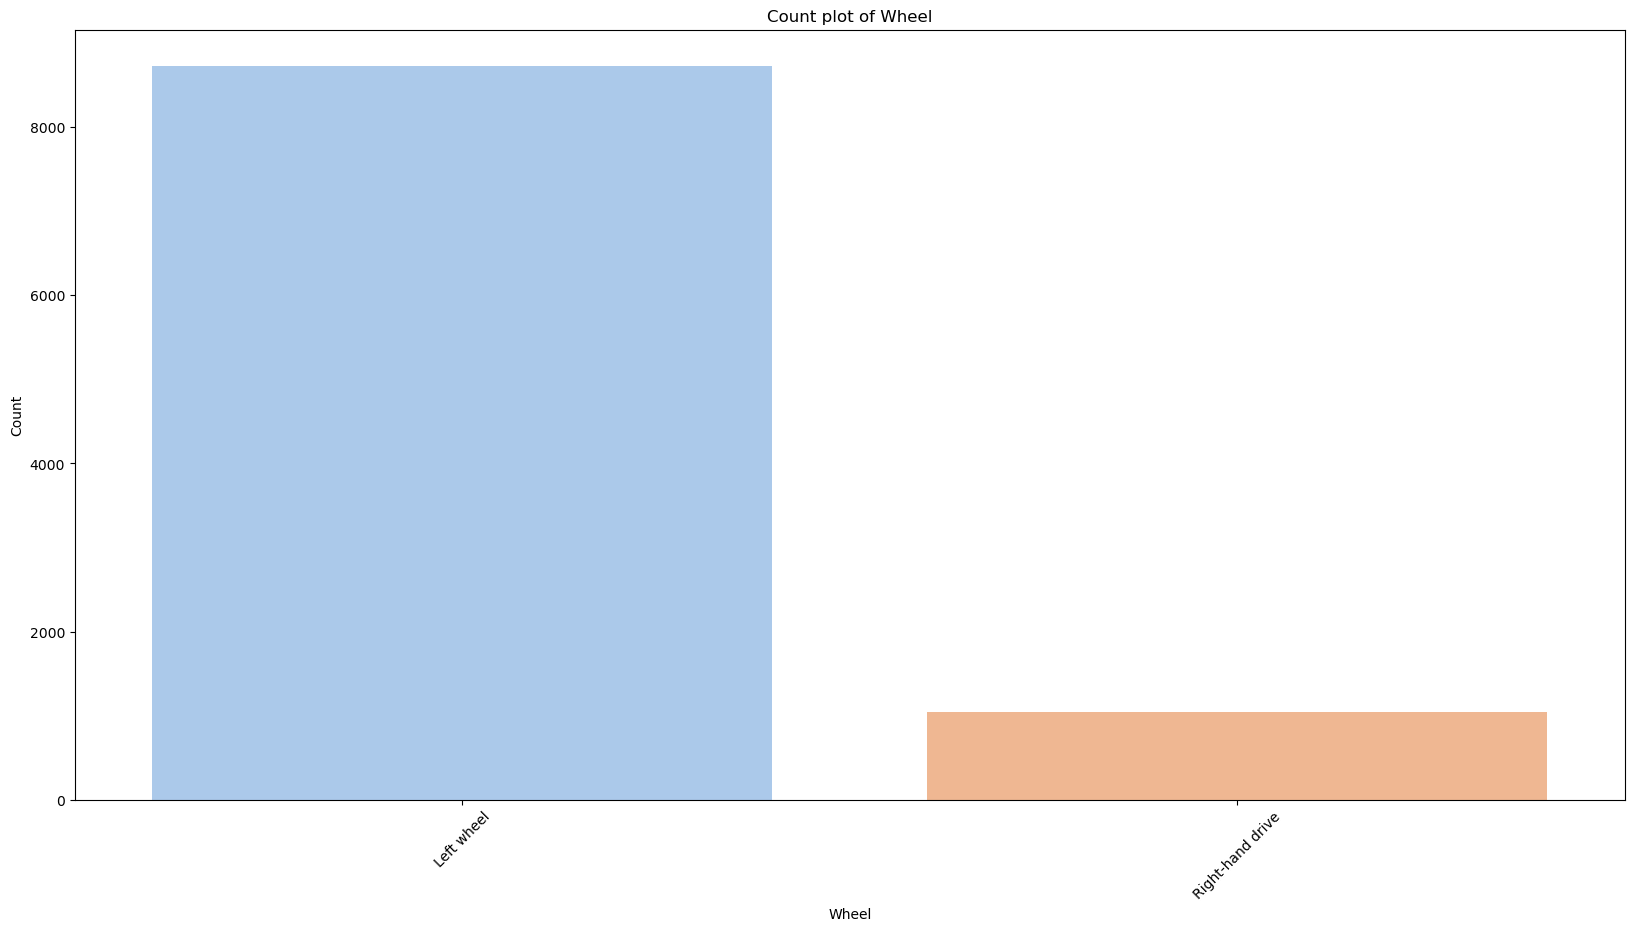

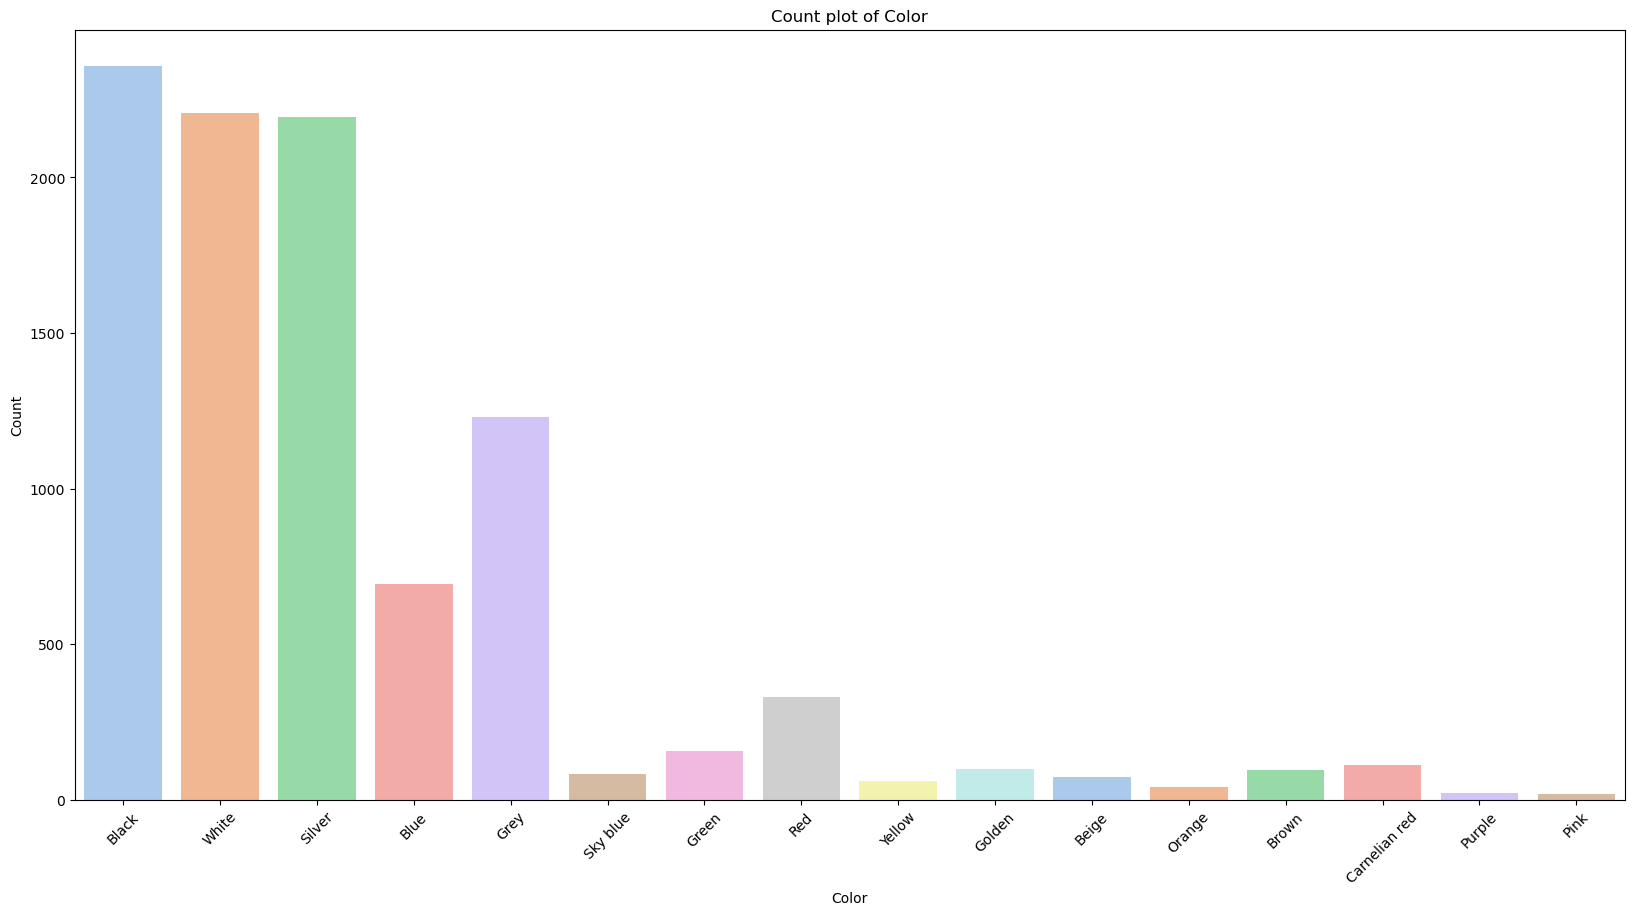

In [203]:
for col in categorical_cols:
    plt.figure(figsize=(20,10))
    sns.countplot(data=df, x=col, hue=col, palette='pastel')
    plt.title(f'Count plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45);

In [344]:
df.columns

Index(['ID', 'Price', 'Levy', 'Manufacturer', 'Model', 'Prod._year',
       'Category', 'Leather_interior', 'Fuel_type', 'Engine_volume', 'Mileage',
       'Cylinders', 'Gear_box_type', 'Drive_wheels', 'Doors', 'Wheel', 'Color',
       'Airbags', 'Turbo_engine'],
      dtype='object')

In [347]:
# Drop features that offer no trend or of no significant importance
# Not dropping engine vol or turbo_engine because this is a used car and it most business settings, that affects its resale value
# Drop the ID col and Doors cols ::: ID cols offers no value or trend, Doors col  is populated with the wrong data
cols_to_drop = ['ID', 'Category', 'Doors', 'Color', 'Wheel', 'Drive_wheels']
df = df.drop(cols_to_drop, axis=1)
df

,Price,Levy,Manufacturer,Model,Prod._year,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Airbags,Turbo_engine
1,16621,1018,CHEVROLET,Equinox,2011,No,Petrol,3.0,192000,6,Tiptronic,8,Not Turbo
2,8467,906,HONDA,FIT,2006,No,Petrol,1.3,200000,4,Variator,2,Not Turbo
3,3607,862,FORD,Escape,2011,Yes,Hybrid,2.5,168966,4,Automatic,0,Not Turbo
6,1803,761,TOYOTA,Prius,2010,Yes,Hybrid,1.8,258909,4,Automatic,12,Not Turbo
9,26657,906,LEXUS,RX 350,2007,Yes,Petrol,3.5,128500,6,Automatic,12,Not Turbo
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19226,7840,906,NISSAN,Skyline,2003,Yes,Petrol,3.0,220000,6,Tiptronic,0,Not Turbo
19227,29793,1053,MERCEDES-BENZ,E 350,2014,Yes,Diesel,3.5,219030,6,Automatic,12,Not Turbo
19231,5802,1055,MERCEDES-BENZ,E 350,2013,Yes,Diesel,3.5,107800,6,Automatic,12,Not Turbo
19233,15681,831,HYUNDAI,Sonata,2011,Yes,Petrol,2.4,161600,4,Tiptronic,8,Not Turbo


In [207]:
cleaned_df = df.copy()

In [352]:
"""STANDARDIZATION"""
scaler = StandardScaler()

scaled_data = scaler.fit_transform(cleaned_df[['Mileage']])

cleaned_df.loc[:,'Mileage'] = scaled_data

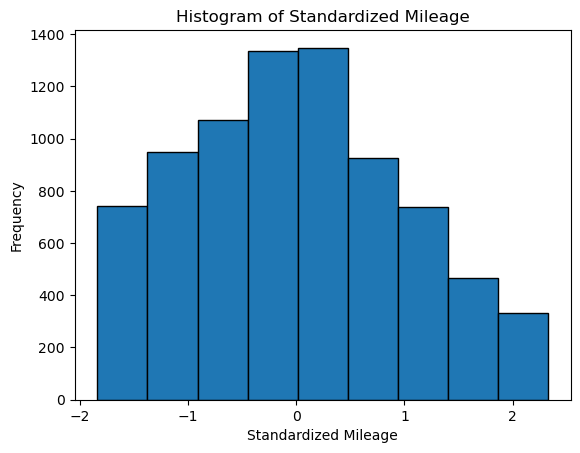

In [353]:
# plot a histogram to showcase the standardized values
plt.hist(cleaned_df.Mileage, bins=9, edgecolor='black')
plt.xlabel('Standardized Mileage')
plt.ylabel('Frequency')
plt.title('Histogram of Standardized Mileage');

In [210]:
model_counts = cleaned_df['Model'].value_counts()

# Filter out Models that appear less than 10 times
cleaned_df = cleaned_df[cleaned_df['Model'].isin(model_counts[model_counts >= 10].index)]
cleaned_df

,Price,Levy,Manufacturer,Model,Prod. year,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Airbags
1,16621,1018,CHEVROLET,Equinox,2011,No,Petrol,3,0.953942,6.0,Tiptronic,8
2,8467,906,HONDA,FIT,2006,No,Petrol,2,1.090471,4.0,Variator,2
3,3607,862,FORD,Escape,2011,Yes,Hybrid,2,0.560843,4.0,Automatic,0
6,1803,761,TOYOTA,Prius,2010,Yes,Hybrid,2,2.095815,4.0,Automatic,12
9,26657,906,LEXUS,RX 350,2007,Yes,Petrol,2,-0.129752,6.0,Automatic,12
...,...,...,...,...,...,...,...,...,...,...,...,...
19226,7840,906,NISSAN,Skyline,2003,Yes,Petrol,3,1.431792,6.0,Tiptronic,0
19227,29793,1053,MERCEDES-BENZ,E 350,2014,Yes,Diesel,2,1.415238,6.0,Automatic,12
19231,5802,1055,MERCEDES-BENZ,E 350,2013,Yes,Diesel,2,-0.483020,6.0,Automatic,12
19233,15681,831,HYUNDAI,Sonata,2011,Yes,Petrol,2,0.435134,4.0,Tiptronic,8


,Price,Levy,Manufacturer,Model,Prod._year,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Airbags
1,16621,1018,CHEVROLET,Equinox,2011,No,Petrol,3,0.953942,6.0,Tiptronic,8
2,8467,906,HONDA,FIT,2006,No,Petrol,2,1.090471,4.0,Variator,2
3,3607,862,FORD,Escape,2011,Yes,Hybrid,2,0.560843,4.0,Automatic,0
6,1803,761,TOYOTA,Prius,2010,Yes,Hybrid,2,2.095815,4.0,Automatic,12
9,26657,906,LEXUS,RX 350,2007,Yes,Petrol,2,-0.129752,6.0,Automatic,12
...,...,...,...,...,...,...,...,...,...,...,...,...
19226,7840,906,NISSAN,Skyline,2003,Yes,Petrol,3,1.431792,6.0,Tiptronic,0
19227,29793,1053,MERCEDES-BENZ,E 350,2014,Yes,Diesel,2,1.415238,6.0,Automatic,12
19231,5802,1055,MERCEDES-BENZ,E 350,2013,Yes,Diesel,2,-0.483020,6.0,Automatic,12
19233,15681,831,HYUNDAI,Sonata,2011,Yes,Petrol,2,0.435134,4.0,Tiptronic,8


In [212]:
year_count = (cleaned_df['Prod._year'].value_counts())

cleaned_df = cleaned_df[cleaned_df['Prod._year'].isin(year_count[year_count >= 5 ].index)]
cleaned_df

,Price,Levy,Manufacturer,Model,Prod._year,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Airbags
1,16621,1018,CHEVROLET,Equinox,2011,No,Petrol,3,0.953942,6.0,Tiptronic,8
2,8467,906,HONDA,FIT,2006,No,Petrol,2,1.090471,4.0,Variator,2
3,3607,862,FORD,Escape,2011,Yes,Hybrid,2,0.560843,4.0,Automatic,0
6,1803,761,TOYOTA,Prius,2010,Yes,Hybrid,2,2.095815,4.0,Automatic,12
9,26657,906,LEXUS,RX 350,2007,Yes,Petrol,2,-0.129752,6.0,Automatic,12
...,...,...,...,...,...,...,...,...,...,...,...,...
19226,7840,906,NISSAN,Skyline,2003,Yes,Petrol,3,1.431792,6.0,Tiptronic,0
19227,29793,1053,MERCEDES-BENZ,E 350,2014,Yes,Diesel,2,1.415238,6.0,Automatic,12
19231,5802,1055,MERCEDES-BENZ,E 350,2013,Yes,Diesel,2,-0.483020,6.0,Automatic,12
19233,15681,831,HYUNDAI,Sonata,2011,Yes,Petrol,2,0.435134,4.0,Tiptronic,8


In [230]:
cleaned_df.groupby('Cylinders')['Cylinders'].value_counts()

Cylinders
1.0        7
2.0       14
3.0       27
4.0     6670
5.0       68
6.0     1045
8.0       68
10.0       2
12.0       7
16.0       2
Name: count, dtype: int64

In [91]:
# Dsplay the Manufacturer, Model against the Category
cat_df = cleaned_df.copy()
cat_df['group'] = cat_df['Manufacturer']
pivot_table = pd.pivot_table(cat_df, columns='Fuel_type', values='Manufacturer', index=['group'], aggfunc='count', fill_value=0)
pivot_table['row_sum'] = pivot_table.sum(axis=1)
pivot_table = pivot_table[['row_sum'] + [col for col in pivot_table.columns if col != 'row_sum']]

pivot_table.sort_values(ascending=False, by='row_sum').head()

Fuel_type,row_sum,CNG,Diesel,Hybrid,Hydrogen,LPG,Petrol,Plug-in Hybrid
group,,,,,,,,
HYUNDAI,2106,0,871,64,1,228,942,0
TOYOTA,1801,12,13,995,0,26,743,12
MERCEDES-BENZ,814,69,306,0,0,39,400,0
CHEVROLET,577,0,215,1,0,13,327,21
FORD,554,4,147,134,0,1,251,17


In [222]:
le = LabelEncoder()

In [224]:
cleaned_df.loc[:,'Leather_interior'] = le.fit_transform(cleaned_df['Leather_interior'])

In [225]:
cleaned_df

,Price,Levy,Manufacturer,Model,Prod._year,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Airbags
1,16621,1018,CHEVROLET,Equinox,2011,0,Petrol,3,0.953942,6.0,Tiptronic,8
2,8467,906,HONDA,FIT,2006,0,Petrol,2,1.090471,4.0,Variator,2
3,3607,862,FORD,Escape,2011,1,Hybrid,2,0.560843,4.0,Automatic,0
6,1803,761,TOYOTA,Prius,2010,1,Hybrid,2,2.095815,4.0,Automatic,12
9,26657,906,LEXUS,RX 350,2007,1,Petrol,2,-0.129752,6.0,Automatic,12
...,...,...,...,...,...,...,...,...,...,...,...,...
19226,7840,906,NISSAN,Skyline,2003,1,Petrol,3,1.431792,6.0,Tiptronic,0
19227,29793,1053,MERCEDES-BENZ,E 350,2014,1,Diesel,2,1.415238,6.0,Automatic,12
19231,5802,1055,MERCEDES-BENZ,E 350,2013,1,Diesel,2,-0.483020,6.0,Automatic,12
19233,15681,831,HYUNDAI,Sonata,2011,1,Petrol,2,0.435134,4.0,Tiptronic,8


In [51]:
# One Hot Encoding for nominal values
cols_to_encode = ['Manufacturer', 'Model', 'Fuel_type', 'Gear_box_type']

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe_data = ohe.fit_transform(cleaned_df[cols_to_encode])
encoded_columns = ohe.get_feature_names_out(cols_to_encode)

encoded_df = pd.DataFrame(ohe_data, columns=encoded_columns)

cleaned_df = pd.concat([cleaned_df.drop(columns=cols_to_encode), encoded_df], axis=1)

cleaned_df

,Price,Levy,Prod._year,Leather_interior,Engine_volume,Mileage,Cylinders,Airbags,Manufacturer_ACURA,Manufacturer_ALFA ROMEO,...,Fuel_type_Diesel,Fuel_type_Hybrid,Fuel_type_Hydrogen,Fuel_type_LPG,Fuel_type_Petrol,Fuel_type_Plug-in Hybrid,Gear_box_type_Automatic,Gear_box_type_Manual,Gear_box_type_Tiptronic,Gear_box_type_Variator
1,16621.0,1018.0,2011.0,0.0,3.0,0.953942,6.0,8.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,8467.0,906.0,2006.0,0.0,2.0,1.090471,4.0,2.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,3607.0,862.0,2011.0,1.0,2.0,0.560843,4.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,1803.0,761.0,2010.0,1.0,2.0,2.095815,4.0,12.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,26657.0,906.0,2007.0,1.0,2.0,-0.129752,6.0,12.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
9763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
9765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
